<img style="float: left;" src="images\EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="images\UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: left;" src="images\urban_rural_scape.png" alt="UoE" width="1000px"/>

# Gaussian Plume Modelling
Jupyter notebook for ECSC09005 Environmental Pollution  
author: John Moncrieff *for* Session 2020-21  [version 0.12, latest 19:51, 7 Feb 2021]
## Background
As discussed in the lecture series, the gaussian plume model has been applied in many different situations either to understand a given air pollution episode or to predict the impact of say a new factory or motorway on future air quality in a particular area. In this jupyter notebook, I want us to explore the sensitivity of ground-level concentration of various pollutants to changes in driving variables such as wind speed and direction and chimney height. Let's examine a real-life example where a local community has been impacted by gas flaring from a local industrial complex in Fife, just north of Edinburgh. If you want some background on this example, have a look at a couple of web reports from the BBC: https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-51498166  and https://www.bbc.co.uk/news/uk-scotland-edinburgh-east-fife-49720751 
<img style="float: right;" src="images\flaring.png" alt="Mossmorran flaring" width="260px"/></p>
## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *scipy* for various mathematical functions
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *ipywidgets* for interactivity
- *config* for python code that just takes up space in the main notebook
- *pyproj* to allow us to convert from GPS coordinates to eastings and northings
- *requests* so we can download a streetmap via a URL query
- *pil* to handle images

In [1]:
import numpy as np
import sys
from scipy.special import erfcinv as erfcinv
import tqdm as tqdm
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import ticker, cm
from src import gauss_func, overlay_on_map, calc_sigmas, smooth
from src import config as cfg
from src import streetimg as stmap
from src.ltgpinterface import ltgpinterface
from src import ytv
from pyproj import Proj, transform
import ipywidgets as widgets
from IPython.display import display
#from io import BytesIO
#from PIL import Image
#import requests
from ipywidgets import interact, interactive, fixed, interact_manual

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
# for Palatino and other serif fonts use:
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
# rc('text', usetex = False)
print('imports OK')

imports OK


### First,  prepare a background image.
This shows the local towns and roads over which we'll project the output from the model. This cell only needs to be run once at the start of the program.

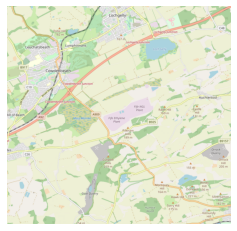

In [2]:
# Get the map Data
# Get more than one tile for a 4 x 4 km box centred on
# the main sources of emission - Fife Ethylene Plant in this example
# I used Google Earth to find the lat-lon coordinates
lat_max = 56.132276
lat_min = 56.060534
lon_min = -3.3733
lon_max = -3.244456
mp = stmap.stmap(lat_max,lat_min,lon_min,lon_max,13)
mp.run()

# image now stored in memory for later use. 
# If the map below looks OK, proceed to initialise the model.

### Configuration - edit the cell below as appropriate.
Now let's load up some default information that will provide the initial configuration of variables such as wind speed and direction, stack height and location etc.

In [3]:
fd = ltgpinterface()
widgets.VBox(children=[fd.h1,fd.h2,fd.h3])


In [4]:
print(fd.stack)

{'wind': 3, 'wdirn': 225, 'stab': 'D', 'height': 10, 'strength': 15, 'heat': 10, 'nstack': 1, 'view': 'plan'}


In [5]:
# SECTION 1: Configuration
# Variables can be changed by the user
RH = 0.90
aerosol_type = cfg.SODIUM_CHLORIDE
x = cfg.x
y = cfg.y
dry_size = 60e-9
humidify = cfg.DRY_AEROSOL

stab1 = 1  # set from 1-6
stability_used = cfg.CONSTANT_STABILITY

output = cfg.PLAN_VIEW #HEIGHT_SLICE # PLAN_VIEW  # SURFACE_TIME # PLAN_VIEW
x_slice = 26  # position (1-50) to take the slice in the x-direction
y_slice = 1  # position (1-50) to plot concentrations vs time

wind = cfg.PREVAILING_WIND
stacks = cfg.ONE_STACK
stack_x = [0., -100., -1000., 300,  130, 330, -1000, -1500, -2000, 2000]
stack_y = [0., 100., 500., 300, 250, 850, -1000, 1500, 2000, 2000]

Q = [600., 500., 600., 700, 1000, 20, 40, 50, 10, 10]  # mass emitted per unit time
H = [80., 65., 60., 50, 15, 10, 15, 35, 10, 10]  # stack height, m
days = 25  # run the model for n days - could be 365!

times = np.mgrid[1:days * 24 + 1:1] / 24.

Dy = 100.
Dz = 100.

# SECTION 2: Act on the configuration information

# Decide which stability profile to use
if stability_used == cfg.CONSTANT_STABILITY:

    stability = stab1 * np.ones((days * 24, 1))
    stability_str = cfg.stability_str[stab1 - 1]
elif stability_used == cfg.ANNUAL_CYCLE:

    stability = np.round(2.5 * np.cos(times * 2. * np.pi / 365.) + 3.5)
    stability_str = 'Annual cycle'
else:
    sys.exit()

# decide what kind of run to do, plan view or y-z slice, or time series
if output == cfg.PLAN_VIEW or output == cfg.SURFACE_TIME or output == cfg.NO_PLOT:

    C1 = np.zeros((len(x), len(y), days * 24))  # array to store data, initialised to be zero

    [x, y] = np.meshgrid(x, y)  # x and y defined at all positions on the grid
    z = np.zeros(np.shape(x))  # z is defined to be at ground level.
elif output == cfg.HEIGHT_SLICE:
    z = np.mgrid[0:500 + cfg.dz:cfg.dz]  # z-grid

    C1 = np.zeros((len(y), len(z), days * 24))  # array to store data, initialised to be zero

    [y, z] = np.meshgrid(y, z)  # y and z defined at all positions on the grid
    x = x[x_slice] * np.ones(np.shape(y))  # x is defined to be x at x_slice
else:
    sys.exit()

# Set the wind based on input flags++++++++++++++++++++++++++++++++++++++++
wind_speed = 4 * np.ones((days * 24, 1))  # m/s
if wind == cfg.CONSTANT_WIND:
    wind_dir = 135. * np.ones((days * 24, 1))
    wind_dir_str = 'Constant wind'
elif wind == cfg.FLUCTUATING_WIND:
    wind_dir = 360. * np.random.rand(days * 24, 1)
    wind_dir_str = 'Random wind'
elif wind == cfg.PREVAILING_WIND:
    wind_dir = -np.sqrt(2.) * erfcinv(2. * np.random.rand(24 * days, 1)) * 2.  # norminv(rand(days.*24,1),0,40)
    # note at this point you can add on the prevailing wind direction, i.e.
    wind_dir = wind_dir + 135
    wind_dir[np.where(wind_dir >= 360.)] = \
        np.mod(wind_dir[np.where(wind_dir >= 360)], 360)
    wind_dir_str = 'Prevailing wind'
else:
    sys.exit()

The gaussian plume equation requires a number of parameters such as wind speed, the effective height of emission, emission strength and the spreading parameters $\sigma_y$ and $\sigma_z$ :  
>$\large x = \frac{Q}{\ \pi\sigma_y \sigma_z u} \exp[ - \frac{1}{\ 2} (\frac{y}{\ \sigma_y})^2] \exp[ - \frac{1}{\ 2} (\frac{H}{\ \sigma_z})^2]$  
where  
$x$ is the ground-level concentration (typically $\mu g m^{-3}$)  
$Q$ is the source emission strength (often $g \ s^{-1}$)  
$u$ is the surface wind speed (usually $m \ s^{-1}$)  
$\sigma_y, \sigma_z$ are the spreading parameters in the $y$ and $z$ directions respectively (units of $m$) and functions of atmospheric stability  
$H$ is the effective plume height ($m$)  
$exp$ is the base of natural logarithms ie the exponential function


### Pasquill dispersion classes  
(Surface wind speed in $m \ s^{-1}$)

| Insolation   | Cloud cover       | Wind Speed | Wind Speed | Wind Speed | Wind Speed | Wind Speed |
|--------------|-------------------|------------|------------|------------|------------|------------|
|              |                   | <2         | 2-3        | 3-5        | 5-6        | >6         |
| Day          | Strong            | A          | A-B        | B          | C          | C          |
|              | Moderate          | A-B        | B          | B-C        | C-D        | D          |
|              | Slight            | B          | C          | C          | D          | D          |
| Day or night | Overcast          | D          | D          | D          | D          | D          |
| Night        | Thin or CC >= 0.5 |            | E          | D          | D          | D          |
|              | CC <=0.4          |            | F          | E          | D          | D          |
|              |                   |            |            |            |            |            |


How do we get $\sigma_y$ and $\sigma_z$?

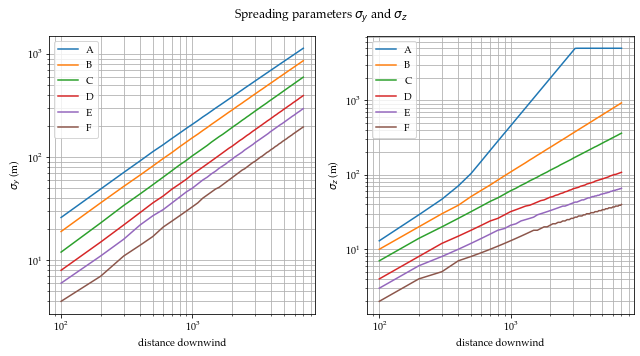

In [6]:
stabs = [1,2,3,4,5,6]
legend = ['A','B','C','D','E','F']
xr = np.arange(100,7100,100)          # every 100 m to 7 km
c = len(stabs)+1
r = np.size(xr,axis=0)
sigy = np.zeros(r)
sigz = np.zeros(r)
sy = np.array([ [0] *c for i in range(r) ])
sz = np.array([ [0] *c for i in range(r) ])

for stablty in stabs:           # loop from very unstable to very stable
    sigy,sigz = calc_sigmas.calc_sigmas(stablty, xr)
    sy[:,stablty] = sigy
    sz[:,stablty] = sigz

fig = plt.figure(figsize=(9,5))
fig.suptitle('Spreading parameters $\sigma_y$ and $\sigma_z$')
ax = plt.subplot(1, 2, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which="both", ls="-")
ax.set_xlabel('distance downwind')
ax.set_ylabel('$\sigma_y$ (m)')
for i in stabs:
    ax.plot(xr, sy[:,i], label=legend[i-1])
ax.legend()
ax1 = plt.subplot(1, 2, 2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, which="both", ls="-")
ax1.set_xlabel('distance downwind')
ax1.set_ylabel('$\sigma_z$ (m)')
for i in stabs:
    ax1.plot(xr, sz[:,i], label=legend[i-1])
ax1.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


<div class="alert alert-block alert-info">
</div>

In [7]:
print(stab)

NameError: name 'stab' is not defined

### Next we do the calculations. Depending on how many stacks you've chosen and the number of days to model, this might take several seconds to complete. A progress bar shows, well, progress.

In [8]:
# SECTION 3: Main loop
# For all times...
C1 = np.zeros((len(x), len(y), len(wind_dir)))
for i in tqdm.tqdm(range(0, len(wind_dir))):
    for j in range(0, stacks):
        C = np.ones((len(x), len(y)))
        C = gauss_func.gauss_func(Q[j], wind_speed[i], wind_dir[i], x, y, z,
                       stack_x[j], stack_y[j], H[j], Dy, Dz, stability[i])
        C1[:, :, i] = C1[:, :, i] + C

100%|██████████| 600/600 [00:01<00:00, 561.51it/s]


### And now the fun part - what does the simulation show?

do not humidify


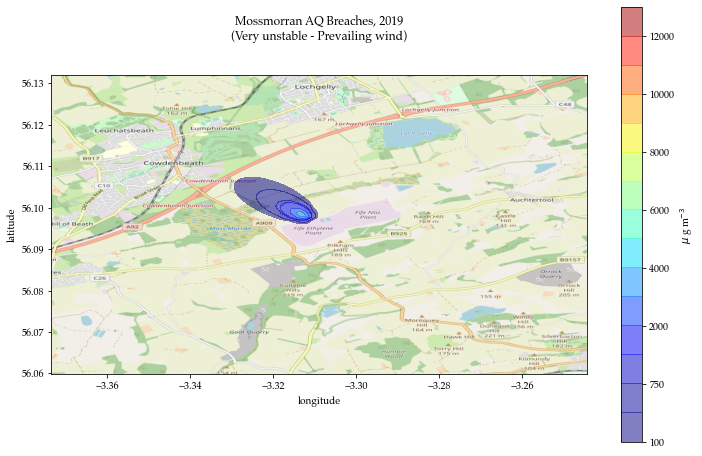

In [9]:
# SECTION 4: Post process / output

# decide whether to humidify the aerosol and hence increase the mass
if humidify == cfg.DRY_AEROSOL:
    print('do not humidify')
elif humidify == cfg.HUMIDIFY:
    mass = np.pi / 6. * rho_s[aerosol_type] * dry_size ** 3.
    moles = mass / Ms[aerosol_type]

    nw = RH * nu[aerosol_type] * moles / (1. - RH)
    mass2 = nw * Mw + moles * Ms[aerosol_type]
    C1 = C1 * mass2 / mass
else:
    sys.exit()

# output the plots
if output == cfg.PLAN_VIEW:
    # Set the map limit around Mossmorran
    extent = [-3.3733, -3.244456, 56.060534, 56.132276]
    fig, ax = plt.subplots(figsize=(12,8))

    # x and y are curently in units of metres from the central point (0,0)
    # convert them to eastings and northings
    xe = cfg.UTM_easting + x
    yn = cfg.UTM_northing + y
    # now convert to lat-lon
    p2 = Proj("+proj=utm +zone=30V, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    xp, yp = p2(xe,yn,inverse=True)
    xmin = np.max(xp)
    xmax = np.min(xp)
    ymax = np.max(yp)
    ymin = np.min(yp)

    data = np.mean(C1, axis=2)*1e6
    # Find max conc so we can set the levels for the contours
    maxc = np.max(data)
    minc = np.min(data)
    # Need a cleverer and automatic solution to get levels.
    plt.contourf(xp, yp, data, alpha=0.5, cmap = 'jet', 
                 levels=[ 100, 250, 750, 1000, 2000, 3000, 4000, 5000, 6000,
                          7000, 8000, 9000, 10000, 11000, 12000, 13000])
    
    ax.imshow(mp.img, extent=(xmax, xmin, ymin, ymax)) 
    #plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('Mossmorran AQ Breaches, 2019' + '\n'
                 +'('+stability_str + ' - ' + wind_dir_str+')', pad=35)
    
    cb1 = plt.colorbar()
    cb1.set_label('$\mu$ g m$^{-3}$')
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmax, xmin)
    plt.savefig("Mossmorran_Concentrations.png")
    plt.show()

elif output == cfg.HEIGHT_SLICE:
    plt.figure()
    plt.ion()
    plt.pcolor(y, z, np.mean(C1, axis=2) * 1e6, cmap='jet', shading='nearest')
    plt.clim((0, 1e2))
    plt.xlabel('y (metres)')
    plt.ylabel('z (metres)')
    plt.title(stability_str + '\n' + wind_dir_str)
    cb1 = plt.colorbar()
    cb1.set_label('$\mu$ g m$^{-3}$')
    plt.show()

elif output == cfg.SURFACE_TIME:
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
    ax1.plot(times, 1e6 * np.squeeze(C1[y_slice, x_slice, :]))
    try:
        ax1.plot(times, smooth(1e6 * np.squeeze(C1[y_slice, x_slice, :]), 24), 'r')
        ax1.legend(('Hourly mean', 'Daily mean'))
    except:
        sys.exit()

    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('Mass loading ($\mu$ g m$^{-3}$)')
    ax1.set_title(stability_str + '\n' + wind_dir_str)

    ax2.plot(times, stability)
    ax2.set_xlabel('time (days)')
    ax2.set_ylabel('Stability parameter')
    f.show()

elif output == NO_PLOT:
    print('don''t plot')
else:
    sys.exit()

### At this point, you can go back to the configuration cell and chose something else to change eg a different wind speed or direction, a different atmospheric stability, more chimneys etc.